In [21]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

Loading the MNLoading the MNIST dataset

60000
Label: 3


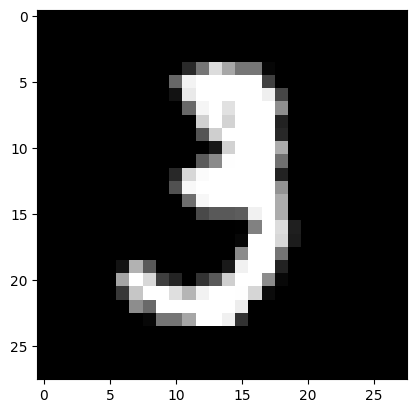

In [22]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [23]:
## MNIST dataset(images and labels)
# Загружаем датасет и применяем транформации
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset)
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28]) 5


In [24]:
print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))
# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


In [25]:
# Создание датасетов для тренировки и валидации

train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

# Задаём размер батча для одной итерации обучения, создаём дата лоадеры для скармливания модели данных датасетов
# We will set shuffle = True for the training dataloader, so that the batches generated in each epoch are different,
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

length of Train Datasets:  50000
length of Validation Datasets:  10000


### Модель

In [26]:
# Logistic Regression model is identical to a linear regression model i.e, there are weights and bias matrices, and the output is obtained using simple matrix operations(pred = x@ w.t() + b).

import torch.nn as nn

input_size = 28 * 28
num_classes = 10

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Кастомная модель - позволяет преобразовать изображения в нужный формат
# и написать код для обучения и валидации
# Здесь модель внутри себя содержит методы training_step, validation_step, что нестандартно
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        # При каждом проходе изображение преобразуются в нужный формат, иначе ошибка
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        # Расчёт accuracy предсказания
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # расчёт loss для всей эпохи
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


## Logistic regression model
# model = nn.Linear(input_size, num_classes)
model = MnistModel()

# print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

for images, labels in train_loader:
    print(labels)
    print(images.shape)
    # Преобразуем форму тензора из (128, 1, 28, 28) в (128, 784)
    outputs = model(images)
    break

tensor([8, 8, 2, 9, 4, 9, 1, 3, 1, 9, 1, 7, 0, 8, 6, 0, 0, 3, 9, 1, 0, 6, 2, 5,
        3, 6, 6, 1, 3, 1, 4, 0, 2, 6, 7, 7, 2, 8, 7, 1, 2, 4, 2, 7, 3, 9, 0, 5,
        3, 8, 8, 4, 5, 0, 5, 7, 4, 5, 5, 2, 4, 8, 0, 2, 4, 2, 1, 0, 4, 4, 7, 1,
        4, 8, 7, 7, 1, 6, 4, 8, 6, 0, 3, 9, 1, 6, 1, 7, 1, 8, 1, 5, 4, 7, 8, 0,
        1, 8, 5, 7, 1, 4, 6, 7, 5, 5, 9, 1, 7, 2, 7, 1, 0, 2, 3, 7, 7, 1, 4, 2,
        7, 2, 0, 7, 0, 0, 2, 1])
torch.Size([128, 1, 28, 28])


In [27]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.1581, -0.2475, -0.0352,  0.1262,  0.4382, -0.1477, -0.1691,  0.1441,
         -0.0443, -0.1330],
        [-0.1391, -0.2837, -0.0871, -0.0347,  0.3465, -0.0638, -0.1893, -0.2571,
         -0.1832,  0.0695]])


Epoch [0], val_loss: 1.9329, val_acc: 0.6400
Epoch [1], val_loss: 1.6681, val_acc: 0.7399
Epoch [2], val_loss: 1.4714, val_acc: 0.7739
Epoch [3], val_loss: 1.3230, val_acc: 0.7916
Epoch [4], val_loss: 1.2090, val_acc: 0.8024
Epoch [0], val_loss: 1.1191, val_acc: 0.8094
Epoch [1], val_loss: 1.0470, val_acc: 0.8150
Epoch [2], val_loss: 0.9878, val_acc: 0.8202
Epoch [3], val_loss: 0.9385, val_acc: 0.8251
Epoch [4], val_loss: 0.8968, val_acc: 0.8278
Epoch [0], val_loss: 0.8610, val_acc: 0.8299
Epoch [1], val_loss: 0.8299, val_acc: 0.8343
Epoch [2], val_loss: 0.8027, val_acc: 0.8371
Epoch [3], val_loss: 0.7787, val_acc: 0.8387
Epoch [4], val_loss: 0.7572, val_acc: 0.8414
Epoch [0], val_loss: 0.7380, val_acc: 0.8438
Epoch [1], val_loss: 0.7206, val_acc: 0.8464
Epoch [2], val_loss: 0.7048, val_acc: 0.8488
Epoch [3], val_loss: 0.6904, val_acc: 0.8501
Epoch [4], val_loss: 0.6772, val_acc: 0.8511
Epoch [0], val_loss: 0.6650, val_acc: 0.8531
Epoch [1], val_loss: 0.6538, val_acc: 0.8542
Epoch [2],

Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

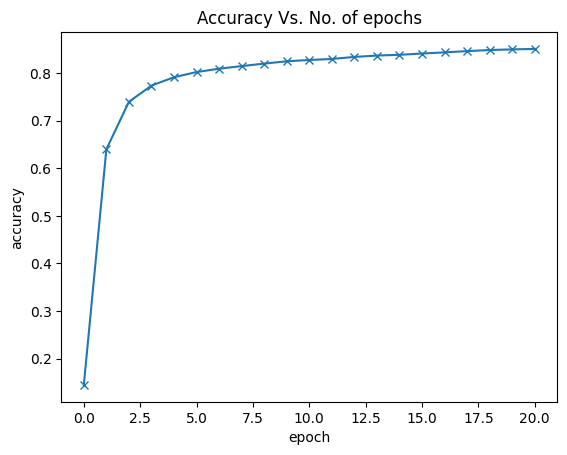

In [28]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

result0 = evaluate(model, val_loader)
result0

# Инициируем 5 эпох

# Стандартный подход
# for epoch in range(num_epochs)


history1 = fit(5, 0.001, model, train_loader, val_loader)
history2 = fit(5, 0.001, model, train_loader, val_loader)
history3 = fit(5, 0.001, model, train_loader, val_loader)
history4 = fit(5, 0.001, model, train_loader, val_loader)
history5 = fit(5, 0.001, model, train_loader, val_loader)

## Replace these values with your result
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

shape:  torch.Size([1, 28, 28])
Label:  7
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


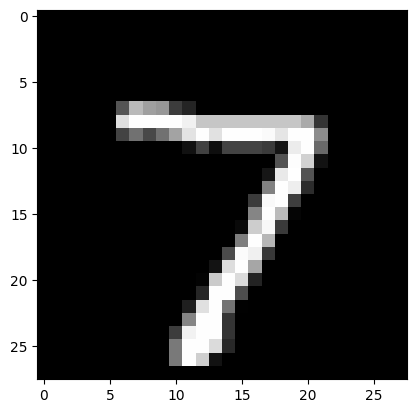

In [29]:
# Тесты с отдельными изображениями

## Define the test dataset
test_dataset = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())

img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("shape: ", img.shape)
print('Label: ', label)

print(img.unsqueeze(0).shape)
print(img.shape)

def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())


Label: 3 , Predicted : 3


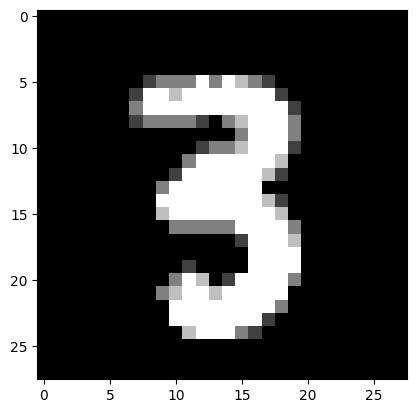

In [67]:
from random import randint
img, label = test_dataset[randint(0,100)]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ', Predicted :', predict_image(img, model))